# 横磁場Ising模型の数値計算

## グラフの辺の生成テスト

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
np.set_printoptions(threshold=16, edgeitems=8)

In [19]:
MaxSteps = int(4.e3)
MaxTrials = int(2.e2)
NumNodes = 256
SeedForConfiguration = 1024

In [4]:
import math

def Generate2dTorusEdges(numNodes):
    columns = math.ceil(math.sqrt(numNodes))
    result = {}
    for i in range(numNodes):
        if i % columns < columns - 1 and i + 1 < numNodes:  # 二つ目の条件はnumNodes以上に頂点が生成されるのを防ぐため．
            result[(i, i + 1)] = +1
        else:
            result[(i + 1 - columns, i)] = +1
        if i // columns < columns - 1 and i + columns < numNodes:
            result[(i, i + columns)] = +1
        else:
            result[(i + columns - numNodes, i)] = +1
    return result

def Generate3dTorusEdges(numNodes):
    sideLength = math.ceil(math.pow(numNodes, 1.0 / 3))  # 1辺の長さ．
    sideArea = math.ceil(math.pow(numNodes, 2.0 / 3))  # 1面に配置される数．
    result = {}
    for i in range(numNodes):
        # 基本は次元の大きさだけ辺を張って，はみ出るか否かに応じて周回させるか決める．
        if i % sideLength < sideLength - 1 and i + 1 < numNodes:
            result[(i, i + 1)] = +1
        else:
            result[(i + 1 - sideLength, i)] = +1
        if (i // sideLength) % sideLength < sideLength - 1 and i + sideLength < numNodes:
            result[(i, i + sideLength)] = +1
        else:
            result[(i + sideLength - sideArea, i)] = +1
        if i // sideArea < sideLength - 1 and i + sideArea < numNodes:
            result[(i, i + sideArea)] = +1
        else:
            result[(i + sideArea - numNodes, i)] = +1
    return result

In [21]:
import simulatorWithCpp as simulator

# Test for the function Generate2dTorusEdges.
quadratic = Generate3dTorusEdges(64)
print(quadratic)
print('\n')
isingModel = simulator.IsingModel({}, quadratic)
for i in range(64):
    for j in range(i + 1, 64):
        isingModel[(i, j)] = -1
isingModel.Write()

{(0, 1): 1, (0, 4): 1, (0, 16): 1, (1, 2): 1, (1, 5): 1, (1, 17): 1, (2, 3): 1, (2, 6): 1, (2, 18): 1, (0, 3): 1, (3, 7): 1, (3, 19): 1, (4, 5): 1, (4, 8): 1, (4, 20): 1, (5, 6): 1, (5, 9): 1, (5, 21): 1, (6, 7): 1, (6, 10): 1, (6, 22): 1, (4, 7): 1, (7, 11): 1, (7, 23): 1, (8, 9): 1, (8, 12): 1, (8, 24): 1, (9, 10): 1, (9, 13): 1, (9, 25): 1, (10, 11): 1, (10, 14): 1, (10, 26): 1, (8, 11): 1, (11, 15): 1, (11, 27): 1, (12, 13): 1, (0, 12): 1, (12, 28): 1, (13, 14): 1, (1, 13): 1, (13, 29): 1, (14, 15): 1, (2, 14): 1, (14, 30): 1, (12, 15): 1, (3, 15): 1, (15, 31): 1, (16, 17): 1, (16, 20): 1, (16, 32): 1, (17, 18): 1, (17, 21): 1, (17, 33): 1, (18, 19): 1, (18, 22): 1, (18, 34): 1, (16, 19): 1, (19, 23): 1, (19, 35): 1, (20, 21): 1, (20, 24): 1, (20, 36): 1, (21, 22): 1, (21, 25): 1, (21, 37): 1, (22, 23): 1, (22, 26): 1, (22, 38): 1, (20, 23): 1, (23, 27): 1, (23, 39): 1, (24, 25): 1, (24, 28): 1, (24, 40): 1, (25, 26): 1, (25, 29): 1, (25, 41): 1, (26, 27): 1, (26, 30): 1, (26, 42):

## 磁化

In [6]:
# 定数の設定．
maxTrial = 250
lenTime = 8
numNodes = 64
numDivision = 200
minTemperature = 0
maxTemperature = 5
minTransversField = 0
maxTransversField = 10

Glauber力学やSCAはエルゴード的なのか？――それに目を瞑って，標本平均を時間平均で置き換える．

In [7]:
%%time

# 古典系での磁化の算出．

temperature = np.linspace(maxTemperature, minTemperature, numDivision)  # 高温側から下げてゆく．
magnetization = np.empty(numDivision)
isingModel = simulator.IsingModel({}, Generate2dTorusEdges(numNodes))
isingModel.Spins = simulator.MakeUniformConfiguration(set(isingModel.Spins.keys()))
isingModel.Algorithm = simulator.Algorithms.SCA  # fcSCAはサンプリングに不適．
isingModel.PinningParameter = 0.5e0 * isingModel.CalcLargestEigenvalue()
spinAtOrigin = np.zeros(maxTrial)
for n in range(numDivision):
    isingModel.Temperature = temperature[n]
    for i in range(maxTrial):
        isingModel.Update()
        spinAtOrigin[i] = isingModel.Spins[0]
    magnetization[n] = np.mean(spinAtOrigin)

fig = plt.figure(figsize=(3, 3), dpi=200)
ax = fig.add_subplot(111, xlabel='Temperature', ylabel='Magnetization')
ax.grid()
ax.scatter(temperature, magnetization, marker='.', s=1)
plt.show()

Wall time: 2.15 s


横磁場Ising模型
$$
    H^{\mathrm{ST}}(\sigma)
    = -\sum_{(t, e) \in [l]\times\mathcal{E}} J_{e} \sigma_{t, \underline{e}}\sigma_{t, \overline{e}}
    - \frac{l K_l}{\beta} \sum_{(t, x) \in [l]\times\Lambda} \sigma_{t, x}\sigma_{t+1, x}
    - h \sum_{(t, x) \in [l]\times\Lambda} \sigma_{t+1, x},
$$
where $K_l = 2^{-1} \log \coth(\beta \Gamma / l)$.
$$
    Z^{\mathrm{ST}}(\beta, \Gamma, h) = \exp\left(-\frac{\beta}{l} H^{\mathrm{ST}}(\sigma)\right)
$$

In [22]:
# 量子系での磁化の算出．

# TODO: 結合係数が 0 でもエラーを吐かないようにする．
# TODO: self-edge の書き替えを不可にする．

def GenerateTransverseIsingEdges(numNodes, lenTime, couplingCoefficient, transversField, temperature):
    sideLength = math.ceil(math.sqrt(numNodes))
    result = {}
    for j in range(lenTime):
        for i in range(numNodes):
            # 空間方向．
            if i % sideLength < sideLength - 1 and i + 1 < numNodes:
                result[(numNodes * j + i, numNodes * j + i + 1)] = couplingCoefficient
            else:
                result[(numNodes * j + i + 1 - sideLength, numNodes * j + i)] = couplingCoefficient
            if i // sideLength < sideLength - 1 and i + sideLength < numNodes:
                result[(numNodes * j + i, numNodes * j + i + sideLength)] = couplingCoefficient
            else:
                result[(numNodes * j + i + sideLength - numNodes, numNodes * j + i)] = couplingCoefficient
            # 虚時間方向．
            verticalEdge = tuple(sorted((numNodes * j + i, (numNodes * j + i + numNodes) % (numNodes * lenTime))))
            if temperature <= 0.e0:
                result[verticalEdge] = 0.e0
            elif transversField == 0.e0:
                result[verticalEdge] = np.inf
            else:
                result[verticalEdge] = -0.5e0 * lenTime * temperature * np.log(np.tanh(transversField / temperature / lenTime))
    return result

In [23]:
rng = np.random.default_rng()
node = rng.integers(low=0, high=numNodes * lenTime - 1)
for key, value in GenerateTransverseIsingEdges(numNodes, lenTime, +1, 1, 5).items():
    if node in key:
        print(key, value)
del rng, node

(278, 342) 73.78175514141327
(334, 342) 1
(341, 342) 1
(342, 343) 1
(342, 350) 1
(342, 406) 73.78175514141327


### 温度変化

横磁場が強いときには相転移が起きているように見える．一方で，横磁場が弱いときには何故か $\pm 1$ を振動する．

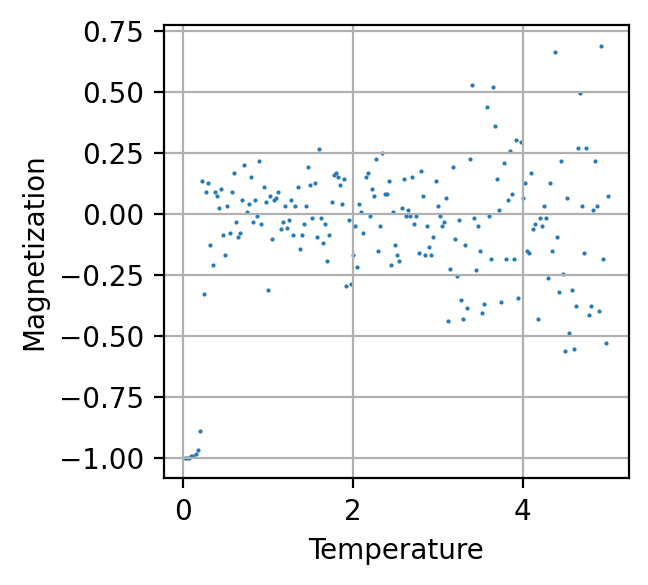

Wall time: 58 s


In [56]:
%%time

couplingCoefficient = +1.e0
transversField = 4.e0
temperature = np.linspace(maxTemperature, minTemperature, numDivision, endpoint=False)  # 高温側から下げてゆく．
magnetization = np.empty(numDivision)
isingModel = simulator.IsingModel({}, GenerateTransverseIsingEdges(numNodes, lenTime, couplingCoefficient, transversField, maxTemperature))
isingModel.Spins = simulator.MakeUniformConfiguration(set(isingModel.Spins.keys()))
isingModel.Algorithm = simulator.Algorithms.SCA
spinAtOrigin = np.ones(maxTrial)
for n in range(numDivision):
    for j in range(lenTime):
        for i in range(numNodes):
            verticalEdge = tuple(sorted((numNodes * j + i, (numNodes * j + i + numNodes) % (numNodes * lenTime))))
            isingModel[verticalEdge] = -0.5e0 * lenTime * temperature[n] * np.log(np.tanh(transversField / temperature[n] / lenTime))
    isingModel.Temperature = temperature[n] * lenTime
    isingModel.PinningParameter = 0.5e0 * isingModel.CalcLargestEigenvalue()  # ここの計算量が大きい．
    for i in range(maxTrial):
        isingModel.Update()
        spinAtOrigin[i] = isingModel.Spins[0]
    magnetization[n] = np.mean(spinAtOrigin)

fig = plt.figure(figsize=(3, 3), dpi=200)
ax = fig.add_subplot(111, xlabel='Temperature', ylabel='Magnetization')
ax.grid()
ax.scatter(temperature, magnetization, marker='.', s=1)
plt.show()

### 横磁場の強さの変化

おおよそ理論どおり．

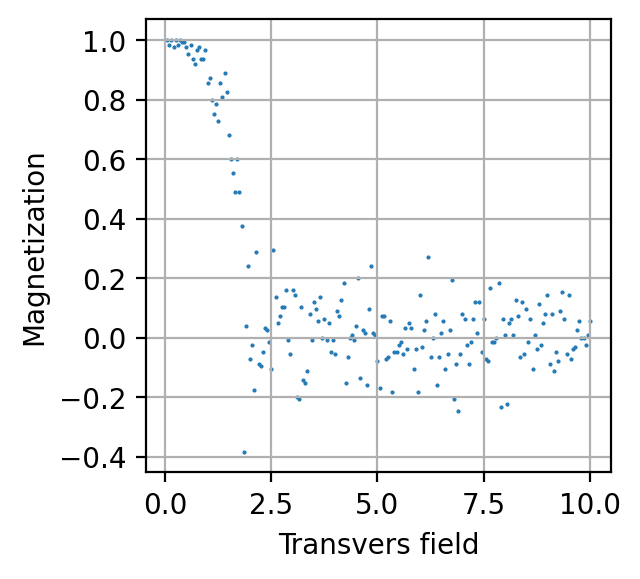

Wall time: 47.6 s


In [59]:
%%time

couplingCoefficient = +1.e0
temperature = 0.5e0
transversField = np.linspace(maxTransversField, minTransversField, numDivision, endpoint=False)
magnetization = np.empty(numDivision)
isingModel = simulator.IsingModel({}, GenerateTransverseIsingEdges(numNodes, lenTime, couplingCoefficient, transversField[n], temperature))
isingModel.Spins = simulator.MakeUniformConfiguration(set(isingModel.Spins.keys()))
isingModel.Temperature = temperature * lenTime
isingModel.Algorithm = simulator.Algorithms.SCA
spinAtOrigin = np.ones(maxTrial)
for n in range(numDivision):
    for j in range(lenTime):
        for i in range(numNodes):
            verticalEdge = tuple(sorted((numNodes * j + i, (numNodes * j + i + numNodes) % (numNodes * lenTime))))
            isingModel[verticalEdge] = -0.5e0 * lenTime * temperature * np.log(np.tanh(transversField[n] / temperature / lenTime))
    isingModel.PinningParameter = 0.5e0 * isingModel.CalcLargestEigenvalue()
    for i in range(maxTrial):
        isingModel.Update()
        spinAtOrigin[i] = isingModel.Spins[0]
    magnetization[n] = np.mean(spinAtOrigin)

fig = plt.figure(figsize=(3, 3), dpi=200)
ax = fig.add_subplot(111, xlabel='Transvers field', ylabel='Magnetization')
ax.grid()
ax.scatter(transversField, magnetization, marker='.', s=1)
plt.show()